## COGS118A - Final Project
### by Justin Laughlin and Stuart Sonatina

#### SMS dataset

In [1]:
# Import packages
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

# Splitting, training, and testing
import sklearn.model_selection as ms

# Text wrangling
import sklearn.feature_extraction.text as txt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import sklearn.naive_bayes as nb

# Visualization
import sklearn.metrics as skm

# magic command to display plots inline
%matplotlib inline

Tutorial
http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

Dataset
https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [2]:
# Use pandas to import data into dataframe
df = pd.read_csv('spam_v_ham.csv', encoding='latin1')
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.columns = ['Class', 'Message']

# replace ham with 0 and spam with 1
df['Class'].replace(['ham','spam'],[0,1],inplace=True)
print(df.shape)
df.head(15)


(5572, 2)


,Class,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [3]:
# create lists for features, X, and classes, Y
X = df['Message'].tolist()
X = [str(i) for i in X]
#Y = df['Class'].tolist()
Y = df['Class'].as_matrix()
Y = [int(i) for i in Y]

[Xtrain, Xtest, Ytrain, Ytest] = ms.train_test_split(X, Y, train_size=0.8)
len(Xtrain)

4457

## Workflow

## Train classifiers
[SGD Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)

[Multinomial Naive Bayes Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)

In [4]:
# In order to make the vectorizer => transformer => classifier easier to work with,
# scikit-learn provides a Pipeline class that behaves like a compound classifier:

# Multinomial Naive Bayes
MNB_clf = Pipeline([('vect', txt.CountVectorizer()),
                    ('tfidf', txt.TfidfTransformer()),
                    ('clf', nb.MultinomialNB()),
                    ])
# Stochastic Gradient Descent (SGD) (Support Vector Machine)
SGD_clf = Pipeline([('vect', txt.CountVectorizer()),
                    ('tfidf', txt.TfidfTransformer()),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                        n_iter=5, random_state=42)),
                    ])


In [5]:
# Use grid search to find best parameters for SGD classifier
SGD_params = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__lowercase': (True, False),
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}
GS_clf = ms.GridSearchCV(SGD_clf, SGD_params, n_jobs=-1)

In [6]:
# Fit models to data
SGD_GS_clf = GS_clf.fit(Xtrain, Ytrain)
MNB_clf = MNB_clf.fit(Xtrain, Ytrain)

## Results

In [7]:
print("\nBest Parameters for SGD:\n")
for param_name in sorted(SGD_params.keys()):
    print("%25s:\t%r" % (param_name, GS_clf.best_params_[param_name]))


Best Parameters for SGD:

               clf__alpha:	0.001
           tfidf__use_idf:	False
          vect__lowercase:	True
        vect__ngram_range:	(1, 2)



 SGD Results:
             precision    recall  f1-score   support

       Spam       0.98      1.00      0.99       968
        Ham       0.98      0.84      0.91       147

avg / total       0.98      0.98      0.98      1115


 MNB Results:
             precision    recall  f1-score   support

       Spam       0.96      1.00      0.98       968
        Ham       1.00      0.70      0.82       147

avg / total       0.96      0.96      0.96      1115



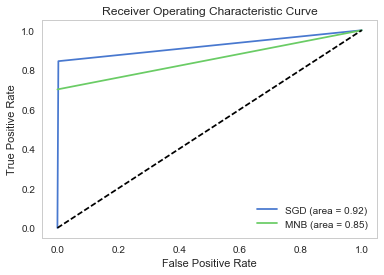

In [8]:
# predicted values
SGDYscore = SGD_GS_clf.predict(Xtest)
MNBYscore = MNB_clf.predict(Xtest)
Yscores = [SGDYscore, MNBYscore]
clfs = ['SGD', 'MNB']
plt.figure(figsize=[6,4])
i=0
for Yscore in Yscores:
    print('\n',clfs[i], "Results:")
    print(skm.classification_report(Ytest, Yscore, target_names=['Spam', 'Ham']))

    # false and true positive rates
    fpr, tpr, thr = skm.roc_curve(np.array(Ytest), Yscore)

    # area under ROC curve
    roc_auc = skm.auc(fpr, tpr)

    # plot curve
    label = '{:s} (area = {:0.2f})'.format(clfs[i], roc_auc)
    plt.plot(fpr, tpr, label=label)
    
    i+=1
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    
plt.grid(False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
